In [1]:
# Origin: Code for week 7 of programming class.
# Author: Tyler Abbot
# Title: week_7_code.ipynb
# Last modified: 2016.08.09

NOTE: If you want to hide the code, use this:

http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/

# Introduction

Today's class will continue our introduction to **working with data in R - fitting linear models**. The notes are written in the Jupyter notebook in order to make things easier to run in class, but the same code is available in an R script in the course repository.

If you would like to follow along using the notebook, you should install <a href="https://www.continuum.io/downloads" target="_blank">Anaconda</a> or<a href="http://conda.pydata.org/miniconda.html" target="_blank">MiniConda</a>. Then you should install the ipython notebook, R, and the R kernel. Run the following in a terminal:
```
conda install -c r ipython-notebook r-irkernel
```
This code will run just as well in RStudio, which you should also become familiar with.

## Today's Objective

Our goal for the day is to become familiar with tools in R used for fitting a simple linear model. We would like to achieve the following objectives:
1. See the basic syntax for linear models.
2. Learn about different plotting options.
3. Study summary statistics from our linear model.
4. Extract data from the linear model object.

If by the end of the class, you feel we haven't sufficiently covered one of these, speak up!

## A Working Example : Market Beta

<a href="https://en.wikipedia.org/wiki/Beta_(finance)" target="_blank">Today's example comes from finance</a>. In general, one can model the returns on an asset as a linear function of market returns:
$$
r = \alpha + \beta(r_m - r_f)
$$
where $(r, r_m, r_f)$ are the returns on an asset, returns on the market, and the risk free rate, respectively. This comes from the theoretical model known as the [Capital Asset Pricing Model (CAPM)](https://en.wikipedia.org/wiki/Capital_asset_pricing_model).

Whether you think this model is accurate (most studies reject the CAPM), it is a simple model and the data is easily available from Yahoo Finance.

## Loading Data
Last week we created a data set of 19 ETF's. This week we are going to use that data set, so let's load it into the namespace:

In [2]:
mydir <- "/home/tmabbot/MEGA/Teaching/Programming/Courses/Week7/data/"
data <- read.csv(paste(mydir, "raw_returns.csv", sep=""),
                 row.names=1)
head(data)

SPY GDX VXX EEM TVIX          XLF          EWJ XIV
2000-08-08  0.0080508475  NA  NA  NA   NA  0.000000000  0.004608295  NA
2000-08-09 -0.0084068937  NA  NA  NA   NA -0.006749156  0.009174312  NA
2000-08-10 -0.0048752590  NA  NA  NA   NA -0.005662514 -0.004545455  NA
2000-08-11  0.0046858375  NA  NA  NA   NA  0.015376073  0.013698630  NA
2000-08-14  0.0127199531  NA  NA  NA   NA  0.012899389 -0.004504505  NA
2000-08-15 -0.0008373459  NA  NA  NA   NA -0.018272638  0.009049774  NA
                    IWM EFA DUST USO         QQQ FXI         EWZ VWO GDXJ XOP
2000-08-08 -0.001838235  NA   NA  NA  0.02240326  NA  0.00000000  NA   NA  NA
2000-08-09 -0.007213093  NA   NA  NA -0.02656042  NA  0.00000000  NA   NA  NA
2000-08-10 -0.005719507  NA   NA  NA -0.01978172  NA -0.03184713  NA   NA  NA
2000-08-11  0.017412935  NA   NA  NA  0.01391788  NA  0.02302632  NA   NA  NA
2000-08-14  0.010391198  NA   NA  NA  0.02127660  NA  0.00000000  NA   NA  NA
2000-08-15 -0.014519056  NA   NA  NA  0.00000000  NA  0.02893891  NA   NA  NA
           HYG
2000-08-08  NA
2000-08-09  NA
2000-08-10  NA
2000-08-11  NA
2000-08-14  NA
2000-08-15  NA

In order to estimate our model, we need to calculate **excess returns**, or returns in excess of the risk free rate. To that end I have created a `.csv` file containing treasury yields, downloaded from [here](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll) (and contacted them to say XML is lame...).

Let's load that data set now:

In [3]:
# NOTE: the check.names fixes the column name correction
treasury <- read.csv(paste(mydir, "treasury.csv", sep=""),
                 row.names=1, check.names=FALSE)
head(treasury)

Date 1 Mo 3 Mo 6 Mo 1 Yr 2 Yr 3 Yr 5 Yr 7 Yr 10 Yr 20 Yr 30 Yr
1 01/02/90  N/A 7.83 7.89 7.81 7.87 7.90 7.87 7.98  7.94   N/A  8.00
2 01/03/90  N/A 7.89 7.94 7.85 7.94 7.96 7.92 8.04  7.99   N/A  8.04
3 01/04/90  N/A 7.84 7.90 7.82 7.92 7.93 7.91 8.02  7.98   N/A  8.04
4 01/05/90  N/A 7.79 7.85 7.79 7.90 7.94 7.92 8.03  7.99   N/A  8.06
5 01/08/90  N/A 7.79 7.88 7.81 7.90 7.95 7.92 8.05  8.02   N/A  8.09
6 01/09/90  N/A 7.80 7.82 7.78 7.91 7.94 7.92 8.05  8.02   N/A  8.10

Next we need to merge our treasury data with our stock data based on the date, but the date format is different. For this we can convert the string into a date object using `as.Date`, specifying the date format:

In [4]:
treasury$Date <- as.Date(treasury$Date, "%m/%d/%y")
head(treasury)

Date 1 Mo 3 Mo 6 Mo 1 Yr 2 Yr 3 Yr 5 Yr 7 Yr 10 Yr 20 Yr 30 Yr
1 1990-01-02  N/A 7.83 7.89 7.81 7.87 7.90 7.87 7.98  7.94   N/A  8.00
2 1990-01-03  N/A 7.89 7.94 7.85 7.94 7.96 7.92 8.04  7.99   N/A  8.04
3 1990-01-04  N/A 7.84 7.90 7.82 7.92 7.93 7.91 8.02  7.98   N/A  8.04
4 1990-01-05  N/A 7.79 7.85 7.79 7.90 7.94 7.92 8.03  7.99   N/A  8.06
5 1990-01-08  N/A 7.79 7.88 7.81 7.90 7.95 7.92 8.05  8.02   N/A  8.09
6 1990-01-09  N/A 7.80 7.82 7.78 7.91 7.94 7.92 8.05  8.02   N/A  8.10

You'll notice the values in `treasury$Date` are not what you would expect. However, they are simply in a particular format:

In [5]:
head(treasury$Date)

[1] "1990-01-02" "1990-01-03" "1990-01-04" "1990-01-05" "1990-01-08"
[6] "1990-01-09"

Now we can merge our two datasets on the date:

In [6]:
# First set the row names to be dates
rownames(treasury) <- treasury$Date
#rownames(data) <- as.Date(rownames(data), "%Y-%m-%d")
treasury$Date <- NULL
head(treasury)
#head(data)

1 Mo 3 Mo 6 Mo 1 Yr 2 Yr 3 Yr 5 Yr 7 Yr 10 Yr 20 Yr 30 Yr
1990-01-02  N/A 7.83 7.89 7.81 7.87 7.90 7.87 7.98  7.94   N/A  8.00
1990-01-03  N/A 7.89 7.94 7.85 7.94 7.96 7.92 8.04  7.99   N/A  8.04
1990-01-04  N/A 7.84 7.90 7.82 7.92 7.93 7.91 8.02  7.98   N/A  8.04
1990-01-05  N/A 7.79 7.85 7.79 7.90 7.94 7.92 8.03  7.99   N/A  8.06
1990-01-08  N/A 7.79 7.88 7.81 7.90 7.95 7.92 8.05  8.02   N/A  8.09
1990-01-09  N/A 7.80 7.82 7.78 7.91 7.94 7.92 8.05  8.02   N/A  8.10

In [7]:
# Try simply using the same merge operation we used before
rn <- rownames(treasury)
temp <- merge(data, treasury, by=0, all=TRUE)
rownames(temp) <- rn
head(temp)

ERROR: Error in `row.names<-.data.frame`(`*tmp*`, value = value): invalid 'row.names' length


In [8]:
dim(temp)
dim(treasury)
dim(data)

[1] 6690   31

[1] 6661   11

[1] 4025   19

In [9]:
# Perform a left merge instead
rn <- rownames(data)
temp <- merge(data, treasury, by=0, all.x=TRUE)[,-1]
rownames(temp) <- rn
head(temp)

SPY GDX VXX EEM TVIX          XLF          EWJ XIV
2000-08-08  0.0080508475  NA  NA  NA   NA  0.000000000  0.004608295  NA
2000-08-09 -0.0084068937  NA  NA  NA   NA -0.006749156  0.009174312  NA
2000-08-10 -0.0048752590  NA  NA  NA   NA -0.005662514 -0.004545455  NA
2000-08-11  0.0046858375  NA  NA  NA   NA  0.015376073  0.013698630  NA
2000-08-14  0.0127199531  NA  NA  NA   NA  0.012899389 -0.004504505  NA
2000-08-15 -0.0008373459  NA  NA  NA   NA -0.018272638  0.009049774  NA
                    IWM EFA ⋯ 3 Mo 6 Mo 1 Yr 2 Yr 3 Yr 5 Yr 7 Yr 10 Yr 20 Yr
2000-08-08 -0.001838235  NA ⋯ 6.26 6.32 6.13 6.16 6.13 6.03 6.04  5.93  6.03
2000-08-09 -0.007213093  NA ⋯ 6.25 6.32 6.17 6.18 6.14 6.03 6.03  5.81  6.02
2000-08-10 -0.005719507  NA ⋯ 6.25 6.31 6.17 6.16 6.11 6.00 6.00  5.76  6.00
2000-08-11  0.017412935  NA ⋯ 6.29 6.35 6.24 6.25 6.19 6.07 6.06  5.79  6.04
2000-08-14  0.010391198  NA ⋯ 6.27 6.36 6.21 6.25 6.20 6.07 6.05  5.78  6.00
2000-08-15 -0.014519056  NA ⋯ 6.28 6.37 6.22 6.28 6.24 6.11 6.08  5.81  6.02
           30 Yr
2000-08-08  5.73
2000-08-09  5.73
2000-08-10  5.68
2000-08-11  5.72
2000-08-14  5.70
2000-08-15  5.72

Great! Now we have our merged data set, we can in face remove some of the columns. We only really need the 3-month treasury bill, and the easiest way to remove this is to only merge this column:

In [32]:
# Perform a left merge instead
rn <- rownames(data)
temp <- merge(data, treasury["3 Mo"], by=0, all.x=TRUE)[,-1]
rownames(temp) <- rn
head(temp)

SPY GDX VXX EEM TVIX          XLF          EWJ XIV
2000-08-08  0.0080508475  NA  NA  NA   NA  0.000000000  0.004608295  NA
2000-08-09 -0.0084068937  NA  NA  NA   NA -0.006749156  0.009174312  NA
2000-08-10 -0.0048752590  NA  NA  NA   NA -0.005662514 -0.004545455  NA
2000-08-11  0.0046858375  NA  NA  NA   NA  0.015376073  0.013698630  NA
2000-08-14  0.0127199531  NA  NA  NA   NA  0.012899389 -0.004504505  NA
2000-08-15 -0.0008373459  NA  NA  NA   NA -0.018272638  0.009049774  NA
                    IWM EFA DUST USO         QQQ FXI         EWZ VWO GDXJ XOP
2000-08-08 -0.001838235  NA   NA  NA  0.02240326  NA  0.00000000  NA   NA  NA
2000-08-09 -0.007213093  NA   NA  NA -0.02656042  NA  0.00000000  NA   NA  NA
2000-08-10 -0.005719507  NA   NA  NA -0.01978172  NA -0.03184713  NA   NA  NA
2000-08-11  0.017412935  NA   NA  NA  0.01391788  NA  0.02302632  NA   NA  NA
2000-08-14  0.010391198  NA   NA  NA  0.02127660  NA  0.00000000  NA   NA  NA
2000-08-15 -0.014519056  NA   NA  NA  0.00000000  NA  0.02893891  NA   NA  NA
           HYG 3 Mo
2000-08-08  NA 6.26
2000-08-09  NA 6.25
2000-08-10  NA 6.25
2000-08-11  NA 6.29
2000-08-14  NA 6.27
2000-08-15  NA 6.28

Lastly, let's convert our treasury rate from annual to daily, convert it into a decimal, and subtract it from all of our returns to get the excess returns.

To do this, we'll first use `lapply`, a new funciton we have yet to use:

In [20]:
?lapply

lapply                  package:base                   R Documentation

_A_p_p_l_y _a _F_u_n_c_t_i_o_n _o_v_e_r _a _L_i_s_t _o_r _V_e_c_t_o_r

_D_e_s_c_r_i_p_t_i_o_n:

     ‘lapply’ returns a list of the same length as ‘X’, each element of
     which is the result of applying ‘FUN’ to the corresponding element
     of ‘X’.

     ‘sapply’ is a user-friendly version and wrapper of ‘lapply’ by
     default returning a vector, matrix or, if ‘simplify = "array"’, an
     array if appropriate, by applying ‘simplify2array()’.  ‘sapply(x,
     f, simplify = FALSE, USE.NAMES = FALSE)’ is the same as ‘lapply(x,
     f)’.

     ‘vapply’ is similar to ‘sapply’, but has a pre-specified type of
     return value, so it can be safer (and sometimes faster) to use.

     ‘replicate’ is a wrapper for the common use of ‘sapply’ for
     repeated evaluation of an expression (which will usually involve
     random number generation).

     ‘simplify2array()’ is the utility called from ‘sapply()’ when
     ‘simplify’ is not false and is similarly called from ‘mapply()’.

_U_s_a_g_e:

     lapply(X, FUN, ...)
     
     sapply(X, FUN, ..., simplify = TRUE, USE.NAMES = TRUE)
     
     vapply(X, FUN, FUN.VALUE, ..., USE.NAMES = TRUE)
     
     replicate(n, expr, simplify = "array")
     
     simplify2array(x, higher = TRUE)
     
_A_r_g_u_m_e_n_t_s:

       X: a vector (atomic or list) or an ‘expression’ object.  Other
          objects (including classed objects) will be coerced by
          ‘base::as.list’.

     FUN: the function to be applied to each element of ‘X’: see
          ‘Details’.  In the case of functions like ‘+’, ‘%*%’, the
          function name must be backquoted or quoted.

     ...: optional arguments to ‘FUN’.

simplify: logical or character string; should the result be simplified
          to a vector, matrix or higher dimensional array if possible?
          For ‘sapply’ it must be named and not abbreviated.  The
          default value, ‘TRUE’, returns a vector or matrix if
          appropriate, whereas if ‘simplify = "array"’ the result may
          be an ‘array’ of “rank” (=‘length(dim(.))’) one higher than
          the result of ‘FUN(X[[i]])’.

USE.NAMES: logical; if ‘TRUE’ and if ‘X’ is character, use ‘X’ as
          ‘names’ for the result unless it had names already.  Since
          this argument follows ‘...’ its name cannot be abbreviated.

FUN.VALUE: a (generalized) vector; a template for the return value from
          FUN.  See ‘Details’.

       n: integer: the number of replications.

    expr: the expression (a language object, usually a call) to
          evaluate repeatedly.

       x: a list, typically returned from ‘lapply()’.

  higher: logical; if true, ‘simplify2array()’ will produce a (“higher
          rank”) array when appropriate, whereas ‘higher = FALSE’ would
          return a matrix (or vector) only.  These two cases correspond
          to ‘sapply(*, simplify = "array")’ or ‘simplify = TRUE’,
          respectively.

_D_e_t_a_i_l_s:

     ‘FUN’ is found by a call to ‘match.fun’ and typically is specified
     as a function or a symbol (e.g., a backquoted name) or a character
     string specifying a function to be searched for from the
     environment of the call to ‘lapply’.

     Function ‘FUN’ must be able to accept as input any of the elements
     of ‘X’.  If the latter is an atomic vector, ‘FUN’ will always be
     passed a length-one vector of the same type as ‘X’.

     Arguments in ‘...’ cannot have the same name as any of the other
     arguments, and care may be needed to avoid partial matching to
     ‘FUN’.  In general-purpose code it is good practice to name the
     first two arguments ‘X’ and ‘FUN’ if ‘...’ is passed through: this
     both avoids partial matching to ‘FUN’ and ensures that a sensible
     error message is given if arguments named ‘X’ or ‘FUN’ are passed
     through ‘...’.

     Simplification 

Let's try applying this to the head of our treasury rate column:

In [21]:
lapply(head(temp[,"3 Mo"]), function(x){x <- x/365; x})

Warning message:
In Ops.factor(x, 365): ‘/’ not meaningful for factorsWarning message:
In Ops.factor(x, 365): ‘/’ not meaningful for factorsWarning message:
In Ops.factor(x, 365): ‘/’ not meaningful for factorsWarning message:
In Ops.factor(x, 365): ‘/’ not meaningful for factorsWarning message:
In Ops.factor(x, 365): ‘/’ not meaningful for factorsWarning message:
In Ops.factor(x, 365): ‘/’ not meaningful for factors

[[1]]
[1] NA

[[2]]
[1] NA

[[3]]
[1] NA

[[4]]
[1] NA

[[5]]
[1] NA

[[6]]
[1] NA

Now we have a problem. Apparently the column is not of a numeric type, but a `factor`. Thanks for nothing R!

Let's see if the same is true for the rest of our data frame. We can do this using `sapply`:

In [23]:
?sapply

lapply                  package:base                   R Documentation

_A_p_p_l_y _a _F_u_n_c_t_i_o_n _o_v_e_r _a _L_i_s_t _o_r _V_e_c_t_o_r

_D_e_s_c_r_i_p_t_i_o_n:

     ‘lapply’ returns a list of the same length as ‘X’, each element of
     which is the result of applying ‘FUN’ to the corresponding element
     of ‘X’.

     ‘sapply’ is a user-friendly version and wrapper of ‘lapply’ by
     default returning a vector, matrix or, if ‘simplify = "array"’, an
     array if appropriate, by applying ‘simplify2array()’.  ‘sapply(x,
     f, simplify = FALSE, USE.NAMES = FALSE)’ is the same as ‘lapply(x,
     f)’.

     ‘vapply’ is similar to ‘sapply’, but has a pre-specified type of
     return value, so it can be safer (and sometimes faster) to use.

     ‘replicate’ is a wrapper for the common use of ‘sapply’ for
     repeated evaluation of an expression (which will usually involve
     random number generation).

     ‘simplify2array()’ is the utility called from ‘sapply()’ when
     ‘simplify’ is not false and is similarly called from ‘mapply()’.

_U_s_a_g_e:

     lapply(X, FUN, ...)
     
     sapply(X, FUN, ..., simplify = TRUE, USE.NAMES = TRUE)
     
     vapply(X, FUN, FUN.VALUE, ..., USE.NAMES = TRUE)
     
     replicate(n, expr, simplify = "array")
     
     simplify2array(x, higher = TRUE)
     
_A_r_g_u_m_e_n_t_s:

       X: a vector (atomic or list) or an ‘expression’ object.  Other
          objects (including classed objects) will be coerced by
          ‘base::as.list’.

     FUN: the function to be applied to each element of ‘X’: see
          ‘Details’.  In the case of functions like ‘+’, ‘%*%’, the
          function name must be backquoted or quoted.

     ...: optional arguments to ‘FUN’.

simplify: logical or character string; should the result be simplified
          to a vector, matrix or higher dimensional array if possible?
          For ‘sapply’ it must be named and not abbreviated.  The
          default value, ‘TRUE’, returns a vector or matrix if
          appropriate, whereas if ‘simplify = "array"’ the result may
          be an ‘array’ of “rank” (=‘length(dim(.))’) one higher than
          the result of ‘FUN(X[[i]])’.

USE.NAMES: logical; if ‘TRUE’ and if ‘X’ is character, use ‘X’ as
          ‘names’ for the result unless it had names already.  Since
          this argument follows ‘...’ its name cannot be abbreviated.

FUN.VALUE: a (generalized) vector; a template for the return value from
          FUN.  See ‘Details’.

       n: integer: the number of replications.

    expr: the expression (a language object, usually a call) to
          evaluate repeatedly.

       x: a list, typically returned from ‘lapply()’.

  higher: logical; if true, ‘simplify2array()’ will produce a (“higher
          rank”) array when appropriate, whereas ‘higher = FALSE’ would
          return a matrix (or vector) only.  These two cases correspond
          to ‘sapply(*, simplify = "array")’ or ‘simplify = TRUE’,
          respectively.

_D_e_t_a_i_l_s:

     ‘FUN’ is found by a call to ‘match.fun’ and typically is specified
     as a function or a symbol (e.g., a backquoted name) or a character
     string specifying a function to be searched for from the
     environment of the call to ‘lapply’.

     Function ‘FUN’ must be able to accept as input any of the elements
     of ‘X’.  If the latter is an atomic vector, ‘FUN’ will always be
     passed a length-one vector of the same type as ‘X’.

     Arguments in ‘...’ cannot have the same name as any of the other
     arguments, and care may be needed to avoid partial matching to
     ‘FUN’.  In general-purpose code it is good practice to name the
     first two arguments ‘X’ and ‘FUN’ if ‘...’ is passed through: this
     both avoids partial matching to ‘FUN’ and ensures that a sensible
     error message is given if arguments named ‘X’ or ‘FUN’ are passed
     through ‘...’.

     Simplification 

In [24]:
sapply(temp, class)

SPY       GDX       VXX       EEM      TVIX       XLF       EWJ       XIV 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
      IWM       EFA      DUST       USO       QQQ       FXI       EWZ       VWO 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
     GDXJ       XOP       HYG      3 Mo 
"numeric" "numeric" "numeric"  "factor"

So, only one issue to deal with. Let's try simply converting using `as.numeric`:

In [25]:
as.numeric(head(temp[,"3 Mo"]))

[1] 572 571 571 575 573 574

That didn't work... The problem is we need to first convert to a `character` vector because R doesn't seem capable of getting its act together:

In [27]:
as.numeric(as.character(head(temp[,"3 Mo"])))

[1] 6.26 6.25 6.25 6.29 6.27 6.28

So let's replace the whole column:

In [41]:
Temp <- temp
Temp[, "3 Mo"] <- as.numeric(as.character(temp[,"3 Mo"]))
sapply(Temp, class)

Warning message:
In eval(expr, envir, enclos): NAs introduced by coercion

SPY       GDX       VXX       EEM      TVIX       XLF       EWJ       XIV 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
      IWM       EFA      DUST       USO       QQQ       FXI       EWZ       VWO 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
     GDXJ       XOP       HYG      3 Mo 
"numeric" "numeric" "numeric" "numeric"

In [35]:
# In case you would like to look at the NA's
temp[is.na(temp[,"3 Mo"]),]

SPY           GDX           VXX           EEM         TVIX
2000-10-09 -0.0075321223            NA            NA            NA           NA
2001-10-08 -0.0065280610            NA            NA            NA           NA
2001-11-12 -0.0061213804            NA            NA            NA           NA
2002-10-14  0.0055845173            NA            NA            NA           NA
2002-11-11 -0.0155047403            NA            NA            NA           NA
2003-10-13  0.0031557999            NA            NA  0.0151413197           NA
2003-11-11 -0.0002852063            NA            NA -0.0128389539           NA
2004-10-11  0.0040885165            NA            NA  0.0052069620           NA
2004-11-11  0.0076087885            NA            NA  0.0113819404           NA
2005-10-10 -0.0084441350            NA            NA -0.0033275937           NA
2005-11-11  0.0034052701            NA            NA  0.0021762544           NA
2006-10-09  0.0005925561 -0.0081466107            NA -0.0037413746           NA
2007-10-08 -0.0053256462 -0.0212766177            NA -0.0106322842           NA
2007-11-12 -0.0099214690 -0.0719539242            NA -0.0553385149           NA
2008-10-13  0.1451977175  0.0174638952            NA  0.2276985836           NA
2008-11-11 -0.0308755273 -0.0652268251            NA -0.0623241229           NA
2009-10-12  0.0039157001 -0.0002071236 -0.0342349631  0.0082811046           NA
2009-11-11  0.0051100102  0.0048329037 -0.0007064422  0.0085533240           NA
2010-11-11 -0.0037673956  0.0073373061  0.0186099111 -0.0097855093           NA
2011-10-10  0.0334457094  0.0357142668 -0.0718837102  0.0447310934 -0.139922984
2011-11-11  0.0188224260  0.0355659477 -0.0426560906  0.0241024090 -0.083151793
2012-10-08 -0.0034213768 -0.0078285552  0.0117233591 -0.0088199998  0.000000000
2012-11-12  0.0007961783 -0.0124333338 -0.0642818451  0.0036585854 -0.102040816
2013-10-14  0.0039939329  0.0026031238  0.0103234687  0.0058370298  0.018867923
2013-11-11  0.0001692933  0.0008236408 -0.0020567462 -0.0051020165 -0.006972112
2014-10-13 -0.0164269398  0.0168512759  0.1034868398  0.0101209583  0.196601942
2014-11-11  0.0009804736  0.0441259574  0.0003585873 -0.0009678441 -0.012396694
2015-10-12  0.0009437342 -0.0295202952 -0.0601786554 -0.0075125489 -0.113365155
2015-11-11 -0.0039316888  0.0133630290  0.0221741482  0.0020426029  0.038720539
                     XLF           EWJ          XIV           IWM           EFA
2000-10-09 -0.0155902004  0.0000000000           NA -0.0022392015            NA
2001-10-08 -0.0224856510  0.0035294118           NA -0.0090799034 -0.0059952997
2001-11-12 -0.0046655912 -0.0084235860           NA  0.0040045537 -0.0134227110
2002-10-14  0.0072779715 -0.0058394161           NA  0.0066958809 -0.0256679706
2002-11-11 -0.0107913669 -0.0228898426           NA -0.0242543946 -0.0195631365
2003-10-13  0.0157835394  0.0041972718           NA  0.0157002215  0.0098906406
2003-11-11 -0.0033172873 -0.0239651416           NA -0.0068706165 -0.0037838018
2004-10-11  0.0027729636  0.0070281124           NA  0.0047120507  0.0024230252
2004-11-11  0.0095140673  0.0049950050           NA  0.0098846456  0.0108925607
2005-10-10 -0.0106382639 -0.0034013605           NA -0.0112324028 -0.0049166461
2005-11-11  0.0034920952  0.0098199673           NA  0.0057531716  0.0052604420
2006-10-09  0.0028440842 -0.0094890511           NA  0.0076190204  0.0007339254
2007-10-08 -0.0136527449 -0.0054607509           NA -0.0074883754 -0.0092636464
2007-11-12  0.0036496683  0.0007462687           NA -0.0096291089 -0.0163954968
2008-10-13  0.0781457616  0.1582200247           NA  0.0863679488  0.1588762710
2008-11-11 -0.0347826087 -0.0416210296           NA -0.0216380178 -0.0329395729
2009-10-12  0.0078740157  0.0020100503           NA  0.0001628460  0.0059815482
2009-11-11  0.0135409614 -0.0010351967           NA  0.0069668651  0.0030221867
2010-11-11 -0.0097783572 -0.0057747834           NA -0.0039434457 -0.0085587131
2011-10-10  0.0515638

Finally, let's carry out our desired calculation, converting to daily returns:

In [42]:
lapply(head(Temp["3 Mo"]), function(x){x <- x/36500; x})

$`3 Mo`
[1] 0.0001715068 0.0001712329 0.0001712329 0.0001723288 0.0001717808
[6] 0.0001720548

In [43]:
Temp["3 Mo"] <- lapply(Temp["3 Mo"], function(x){x <- x/36500; x})

Now, let's get the column names and loop through, subtracting the risk free rate:

In [48]:
for(column in colnames(Temp)[-length(colnames(Temp))]){
    Temp[column] <- Temp[column] - Temp["3 Mo"]
}

Finally, let's drop all rows that contain `NA`:

In [52]:
Temp <- na.omit(Temp)

That's it! We now have a dataset with the excess returns for all our stocks. Let's rename it: 

In [53]:
data <- Temp

## Fitting Our First Linear Model
To start off, let's calculate the beta for the first etf in the list, `GDX`. To do this we define a linear model using the `lm` function:

In [54]:
?lm

lm                    package:stats                    R Documentation

_F_i_t_t_i_n_g _L_i_n_e_a_r _M_o_d_e_l_s

_D_e_s_c_r_i_p_t_i_o_n:

     ‘lm’ is used to fit linear models.  It can be used to carry out
     regression, single stratum analysis of variance and analysis of
     covariance (although ‘aov’ may provide a more convenient interface
     for these).

_U_s_a_g_e:

     lm(formula, data, subset, weights, na.action,
        method = "qr", model = TRUE, x = FALSE, y = FALSE, qr = TRUE,
        singular.ok = TRUE, contrasts = NULL, offset, ...)
     
_A_r_g_u_m_e_n_t_s:

 formula: an object of class ‘"formula"’ (or one that can be coerced to
          that class): a symbolic description of the model to be
          fitted.  The details of model specification are given under
          ‘Details’.

    data: an optional data frame, list or environment (or object
          coercible by ‘as.data.frame’ to a data frame) containing the
          variables in the model.  If not found in ‘data’, the
          variables are taken from ‘environment(formula)’, typically
          the environment from which ‘lm’ is called.

  subset: an optional vector specifying a subset of observations to be
          used in the fitting process.

 weights: an optional vector of weights to be used in the fitting
          process.  Should be ‘NULL’ or a numeric vector.  If non-NULL,
          weighted least squares is used with weights ‘weights’ (that
          is, minimizing ‘sum(w*e^2)’); otherwise ordinary least
          squares is used.  See also ‘Details’,

na.action: a function which indicates what should happen when the data
          contain ‘NA’s.  The default is set by the ‘na.action’ setting
          of ‘options’, and is ‘na.fail’ if that is unset.  The
          ‘factory-fresh’ default is ‘na.omit’.  Another possible value
          is ‘NULL’, no action.  Value ‘na.exclude’ can be useful.

  method: the method to be used; for fitting, currently only ‘method =
          "qr"’ is supported; ‘method = "model.frame"’ returns the
          model frame (the same as with ‘model = TRUE’, see below).

model, x, y, qr: logicals.  If ‘TRUE’ the corresponding components of
          the fit (the model frame, the model matrix, the response, the
          QR decomposition) are returned.

singular.ok: logical. If ‘FALSE’ (the default in S but not in R) a
          singular fit is an error.

contrasts: an optional list. See the ‘contrasts.arg’ of
          ‘model.matrix.default’.

  offset: this can be used to specify an _a priori_ known component to
          be included in the linear predictor during fitting.  This
          should be ‘NULL’ or a numeric vector of length equal to the
          number of cases.  One or more ‘offset’ terms can be included
          in the formula instead or as well, and if more than one are
          specified their sum is used.  See ‘model.offset’.

     ...: additional arguments to be passed to the low level regression
          fitting functions (see below).

_D_e_t_a_i_l_s:

     Models for ‘lm’ are specified symbolically.  A typical model has
     the form ‘response ~ terms’ where ‘response’ is the (numeric)
     response vector and ‘terms’ is a series of terms which specifies a
     linear predictor for ‘response’.  A terms specification of the
     form ‘first + second’ indicates all the terms in ‘first’ together
     with all the terms in ‘second’ with duplicates removed.  A
     specification of the form ‘first:second’ indicates the set of
     terms obtained by taking the interactions of all terms in ‘first’
     with all terms in ‘second’.  The specification ‘first*second’
     indicates the _cross_ of ‘first’ and ‘second’.  This is the same
     as ‘first + second + first:second’.

     If the formula includes an ‘offset’, this is evaluated and
     subtracted from the response.

     If ‘response’ is a matrix a linear model is fitted separately by
   

The syntax for the `fomula` variable is in S and takes a moment to get used to, but is easier if you see it:

In [56]:
first_model <- lm(data$GDX ~ data$SPY)

The `~` acts as an equal sign and we are essentially saying that excess returns on `GDX` are a linear function of excess market returns, here approximated by the `SPY`. The model is automatically fit with a constant, so if you would like to fit a model with no intercept you must include `-1` or `0 +` in the formula.

Let's take a look at our model:

In [58]:
class(first_model)
first_model

[1] "lm"


Call:
lm(formula = data$GDX ~ data$SPY)

Coefficients:
(Intercept)     data$SPY  
 -0.0004497    0.4814519  


The `lm` class has several useful methods (available in the help file), only some of which we'll use today. First of all, there is the **`summary`** function, which gives statistical properties and tests of the fitted model: 

In [60]:
summary(first_model)


Call:
lm(formula = data$GDX ~ data$SPY)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.107475 -0.015264 -0.001106  0.014525  0.114312 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0004497  0.0006731  -0.668    0.504    
data$SPY     0.4814519  0.0701224   6.866 9.86e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0253 on 1414 degrees of freedom
Multiple R-squared:  0.03226,	Adjusted R-squared:  0.03158 
F-statistic: 47.14 on 1 and 1414 DF,  p-value: 9.865e-12


All of the data within the summary can be called as a method of the linear model, e.g. the coefficients:

In [65]:
first_model$coefficients

(Intercept)      data$SPY 
-0.0004497139  0.4814518772

Another useful function is **`abline`**, which can be directly called using the linear model to add the fitted model line to a graph:

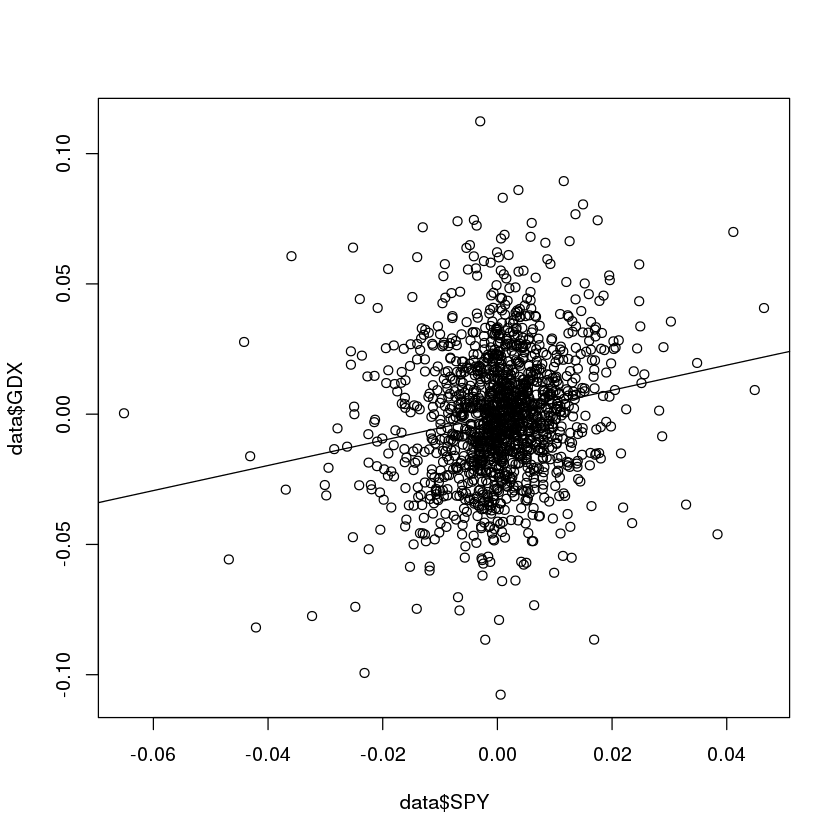

In [63]:
plot(data$SPY, data$GDX)
abline(first_model)

If we use **`plot`**, we get a plot of the residuals with a fitted line:

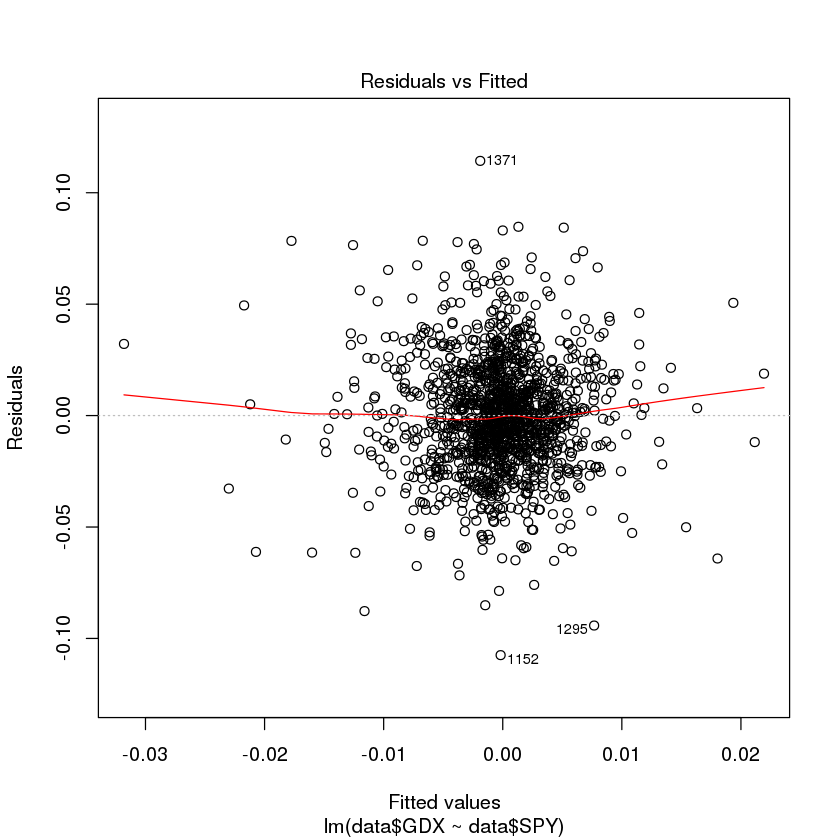

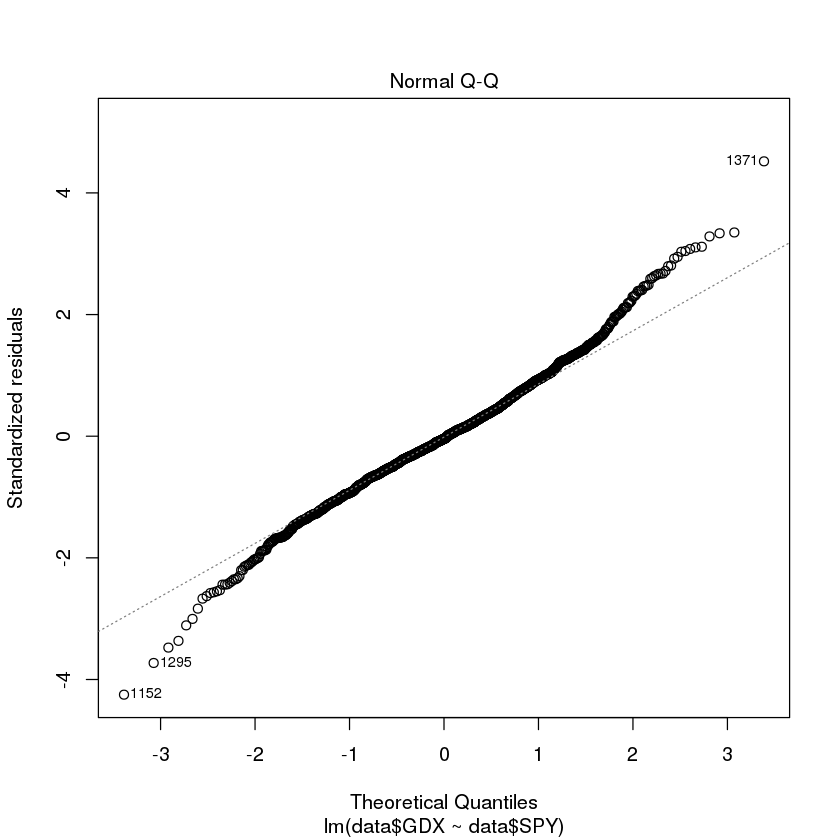

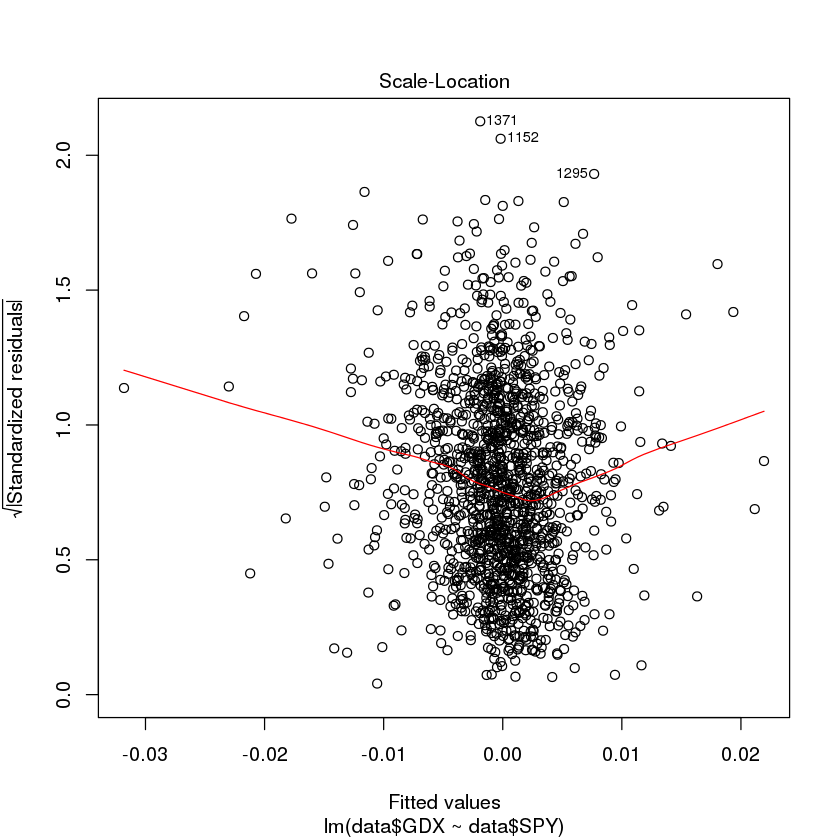

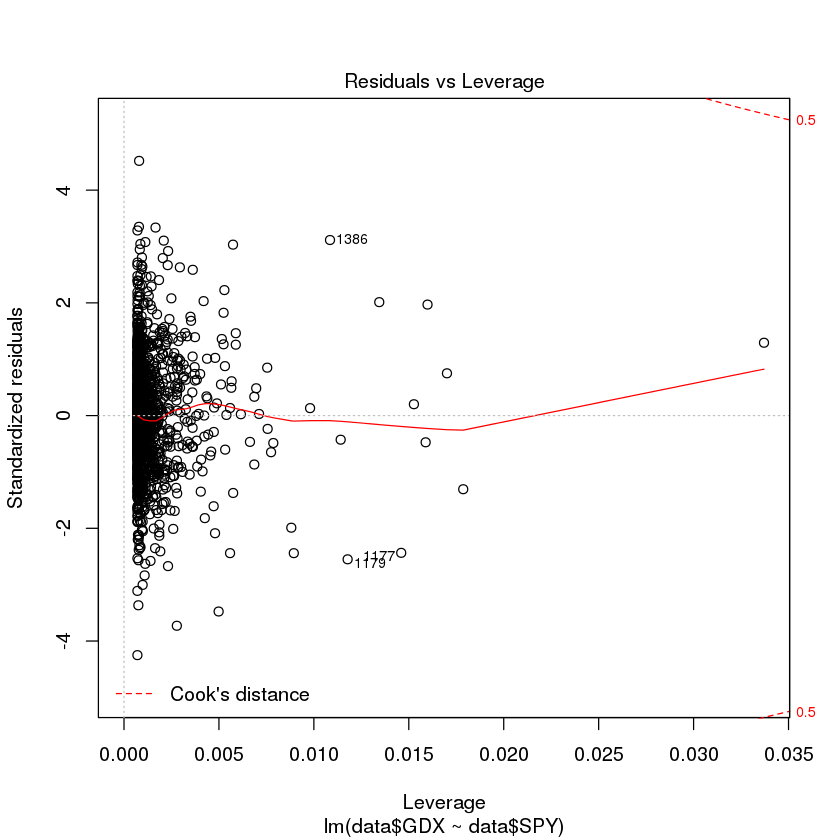

In [64]:
plot(first_model)

This is so cool! Our model is pretty awful, but the p-value is very small for the fitted value of $\beta$, so we can't reject it.

What about a stock with a negative covariance with the `SPY`?

## A Negatively Correlated Stock
Last week we saw that our 3rd ETF, `VXX`, covaries negatively with the `SPY`. What do you think this implies about the value of $\beta$?

Let's check it out:

In [66]:
sec_model <- lm(data$VXX ~ data$SPY)
summary(sec_model)


Call:
lm(formula = data$VXX ~ data$SPY)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.08039 -0.01735 -0.00528  0.00723  2.94130 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.003418   0.002970   1.151     0.25    
data$SPY    -3.284673   0.309435 -10.615   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1117 on 1414 degrees of freedom
Multiple R-squared:  0.07381,	Adjusted R-squared:  0.07315 
F-statistic: 112.7 on 1 and 1414 DF,  p-value: < 2.2e-16


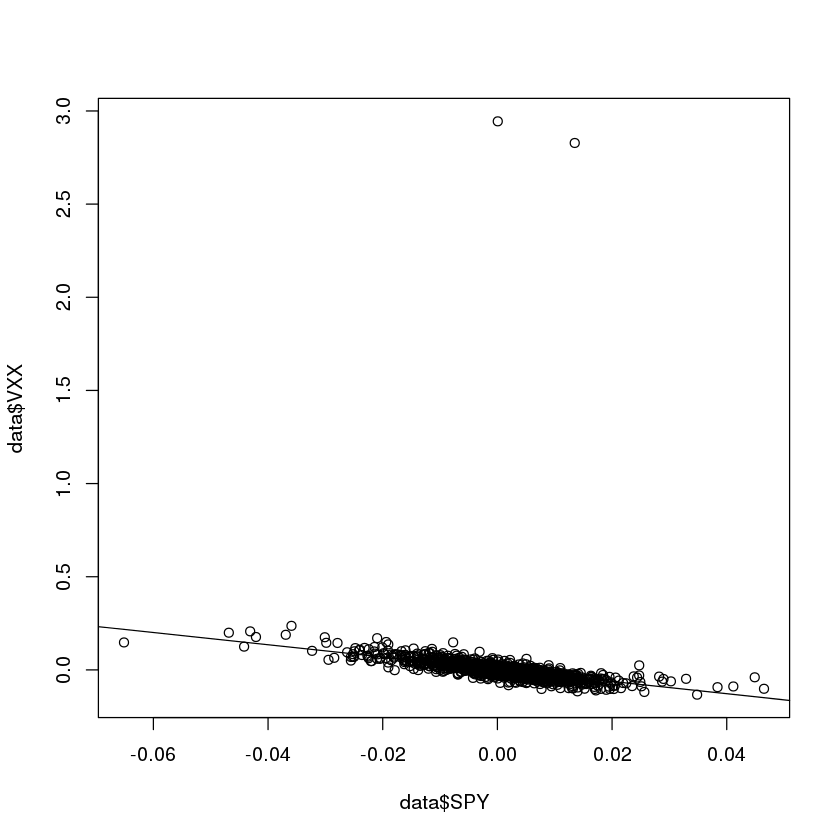

In [67]:
plot(data$SPY, data$VXX)
abline(sec_model)

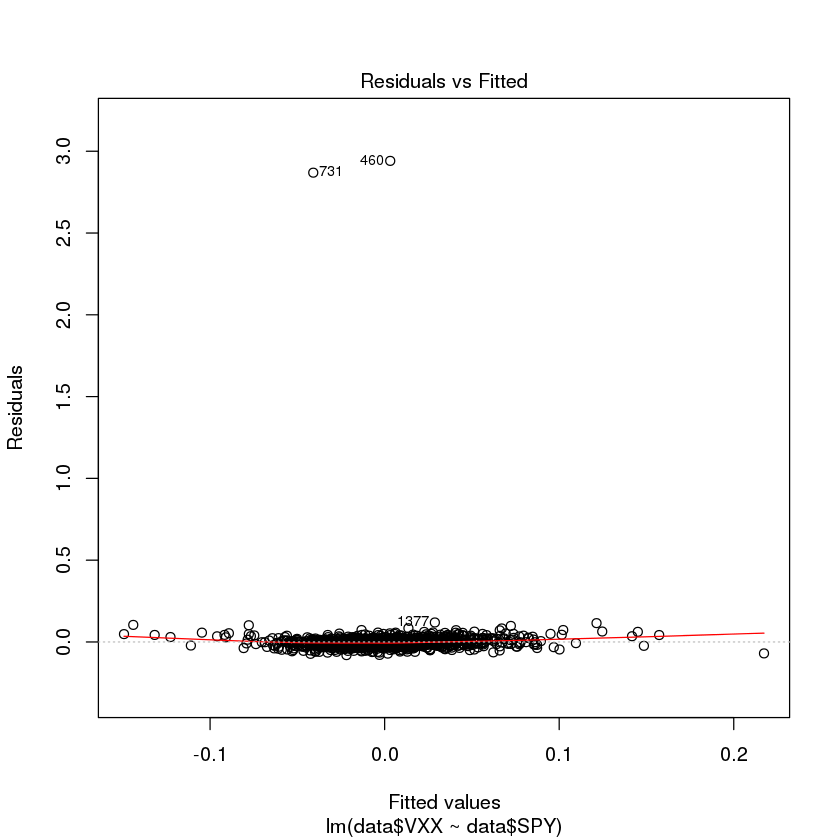

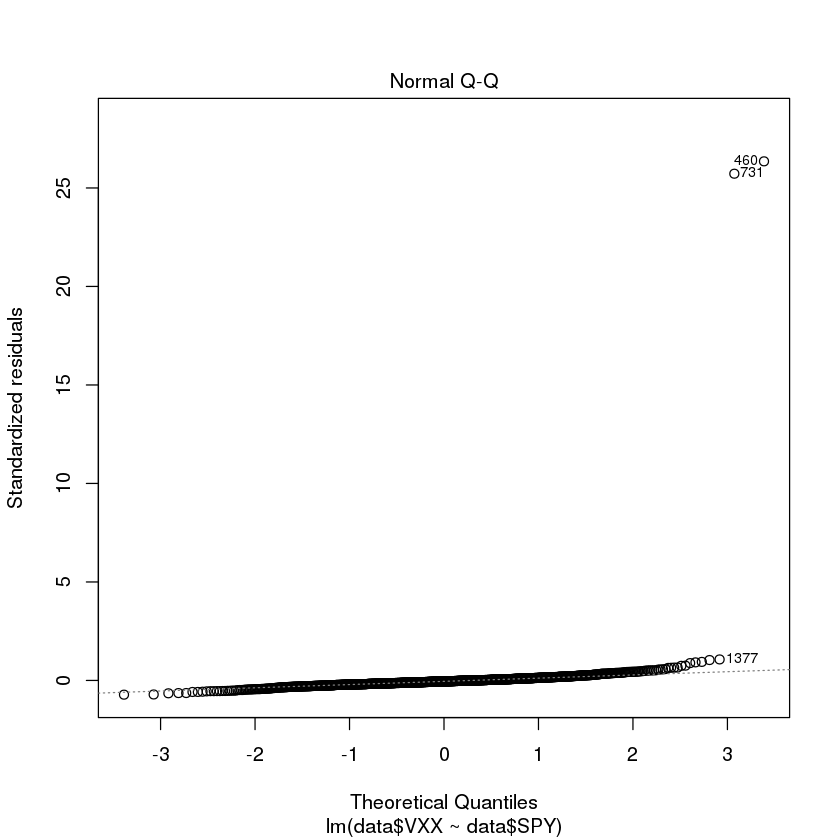

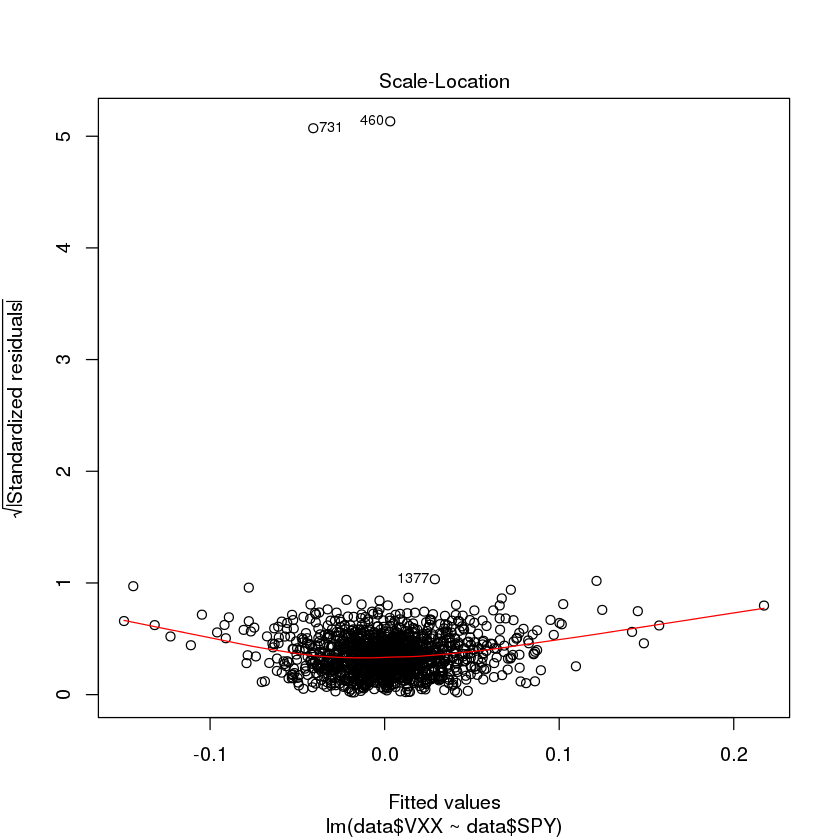

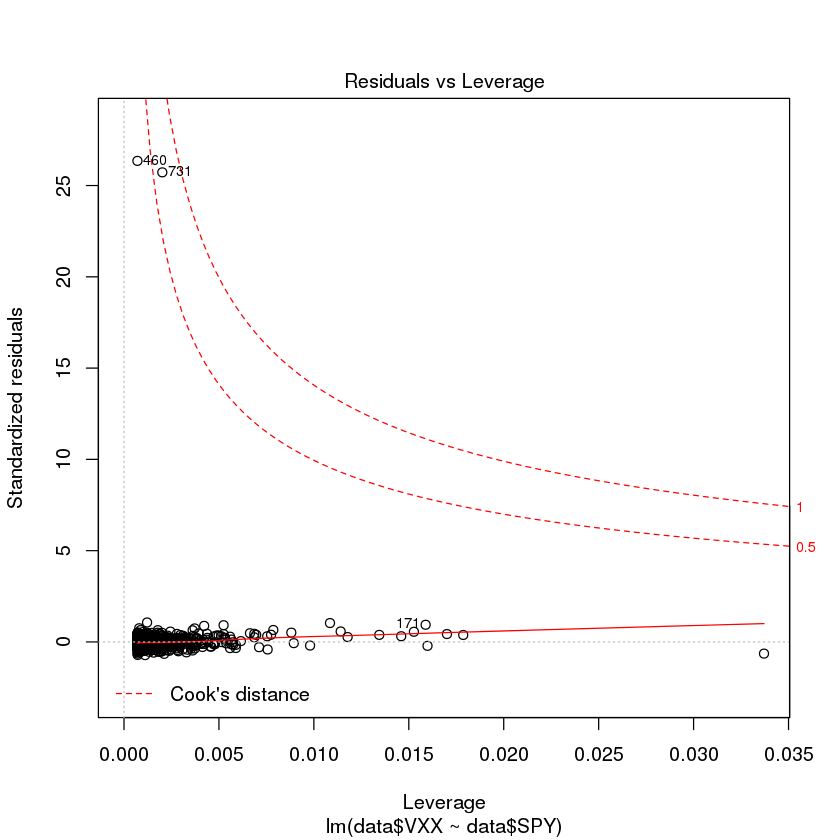

In [68]:
plot(sec_model)

Cool, there are a couple of outliers, but for today we aren't looking to be perfect. Now what if we wanted to extract some data and use it for a simulation.

## Simulation Based on Model Output
Although this is a simple model, we can use the information we've gained from our models. For example, we can use the coefficients generated to learn something about returns:

In [69]:
first_model$coefficients
sec_model$coefficients

(Intercept)      data$SPY 
-0.0004497139  0.4814518772

(Intercept)     data$SPY 
 0.003417996 -3.284672985

This output tells us that `GDX` covaries positively with the market while the `VXX` covaries negatively, while the intercepts differ to a greater degree. The ratios are 

In [138]:
a_ratio <- -as.numeric(first_model$coefficients[1]/sec_model$coefficients[1])
b_ratio <- -as.numeric(first_model$coefficients[2]/sec_model$coefficients[2])
a_ratio
b_ratio

[1] 0.1315724

[1] 0.1465753

Because of this, perhaps we can benefit from building a **beta-neutral portfolio**. The idea goes that if we buy shares in `VXX` and short shares in `GDX` at the ratio `b_ratio`, the volatility of each should offset, but we will earn the difference in the intercepts. To see this, we'll assume we start with $\$100$ and that we build a portfolio whose weights have a ratio equal $b =$ `b_ratio`:
$$
\begin{align*}
    &&\frac{\pi}{1- \pi} &= b\\
    & \Leftrightarrow & \pi &= \frac{b}{1 + b} 
\end{align*}
$$

In [178]:
pi <- b_ratio/(1 + b_ratio)
pi

[1] 0.1278375

In other words, we will borrow $\$17$ worth of shares in `GDX` and sell them into the market. We'll use the proceeds and our $\$100$ to purchase $\$117$ worth of shares in `VXX`. We can then track the value of our portfolio throughout the period. Here's how that looks:

In [140]:
# Try dropping outliers
keep <- sapply(names(data), function(f) (data[,f] <= quantile(data[,f], probs = c(0.9))) )
copy <- data
data <- data[apply(keep, 1, all),]

In [179]:
# Add several columns to our data frame
data['portfolio_value'] <- NA
data[1, 'portfolio_value'] <- 100
data['portfolio_returns'] <- NA
for(row in rownames(data)){
    data[row, 'portfolio_returns'] <- (1 - pi)*data[row, 'VXX'] + pi*data[row, 'GDX']
}
i <- 1
while(i < dim(data)[1]){
    data[i + 1, 'portfolio_value'] <- data[i, 'portfolio_value']*(1 + data[i, 'portfolio_returns'])
    i <- i + 1
}
data

SPY                   GDX                   VXX
2011-06-22  -0.00602603282799002    0.0120342978994471   0.00986218790385113
2011-07-08  -0.00709307216092122  0.000710306971080582    0.0119334887766567
2011-07-28  -0.00291160373886152  -0.00598685282873896    0.0231740917701503
2011-11-22  -0.00392835994828705    0.0149460710059223   -0.0235597186738725
2012-01-04   0.00156805597636307  -0.00111573383953983   -0.0196025687115862
2012-01-06  -0.00257782081337892   -0.0102047034107285   -0.0151943463948178
2012-03-02  -0.00305134794107126   -0.0196833996418476   0.00579766818182164
2012-03-28  -0.00496100517339404    -0.019637809371938   0.00755561520250081
2012-03-29  -0.00171050325914396   0.00265495936325027  -0.00519522421329705
2012-04-05 -0.000502749477800683   -0.0109205820809373    0.0217369958621987
2012-04-18  -0.00338127496410995   -0.0101908371419292    0.0144505557882234
2012-04-19  -0.00642281091534797 -0.000430826227071747   0.00712131506849317
2012-04-30  -0.00370673576352289  -0.00876342367390517    0.0222330834836191
2012-05-24   0.00196289868130182     0.004272732917435    0.0073973589419549
2012-07-12  -0.00484776790596089  -0.00619768835135628   0.00568716070071516
2012-08-02  -0.00690701570340812   -0.0049728562859691     -0.02324084656302
2012-08-10   0.00163295473641709   0.00650527179758085   -0.0180594895110662
2012-08-20  6.73829851001857e-05   0.00617252666308128 -3.01369863013699e-06
2012-08-23  -0.00818241676409475  -0.00168726633020915    0.0181004345772321
2012-08-27   0.00020897132758664    -0.014087478697579   0.00970572416544753
2012-08-28 -0.000991852393286159  -0.00106892304943109    0.0174797777564901
2012-08-30  -0.00721064048243694  -0.00797857520729142    0.0222957165346931
2012-09-17  -0.00339882993756606  0.000553948786387328   -0.0119855845047302
2012-09-20  6.52207949261703e-05  -0.00785116102755605   -0.0113024487268787
2012-09-21  -0.00572867629777378   0.00827513184445034  -0.00571729941291592
2012-12-04  -0.00141664572985713   0.00365479039445458    0.0142168369935493
2012-12-10  0.000418831896423005    0.0128431689080167    0.0149431179780433
2012-12-24  -0.00308300122457576  -0.00730580496886128    -0.017825921099775
2012-12-27  -0.00134259389722399   0.00642077581948966 -0.000891432984778977
2013-01-07  -0.00273467734681171   -0.0187533398796324  -0.00109081076970347
⋮                              ⋮                     ⋮                     ⋮
2014-08-07  -0.00541555593195338   0.00262184564972027    0.0209369250594847
2014-08-20   0.00267040470272119  -0.00112514980108701   0.00763523138231638
2014-08-22  -0.00155469660452508   0.00114992606838275  -0.00395616186586075
2014-08-28 -0.000550140269868177    0.0134039267070579    0.0158094547620338
2014-09-12  -0.00584177601548157   -0.0160698104091526    0.0221423449119373
2014-10-01   -0.0135524611813863   0.00187206432667581    0.0227704270387585
2014-10-27  -0.00137502745251788    -0.017587163362236   -0.0150744107775155
2014-11-12  -0.00107796006951682   0.00109720184062029    0.0136195595816763
2015-02-11  0.000579944591105084   -0.0197371151503827   0.00482624157330877
2015-02-23 -0.000142557031031879   0.00440042983469775   0.00309755887400649
2015-03-05   0.00109354426036163   0.00199541003902799    -0.012491363980871
2015-03-13  -0.00613314428963859 -8.21917808219178e-07    0.0225610412554088
2015-03-19  -0.00456229187917708  -0.00690108731058954 -8.21917808219178e-07
2015-03-24   -0.0056195622309198  -0.00557021883128144  -0.00356631656644162
2015-05-07   0.00398935315644642   0.00608805713284264  -0.00731957830383314
2015-05-11  -0.00477322549866626   0.00250325788873557    0.0247447201409047
2015-05-20 -0.000704645962874831   0.00399945205479452   0.00208936856941917
2015-05-28  -0.00112857676237668   0.00823012683859079    0.0101654825728358
2015-06-08  -0.00615017837568404    0.0100897335205407    0.0193711274474648
2015-06-11   0.00317567396903726   -0.0116035973694025   -0.0238355407025739
2015-06-12  -0.0076554643

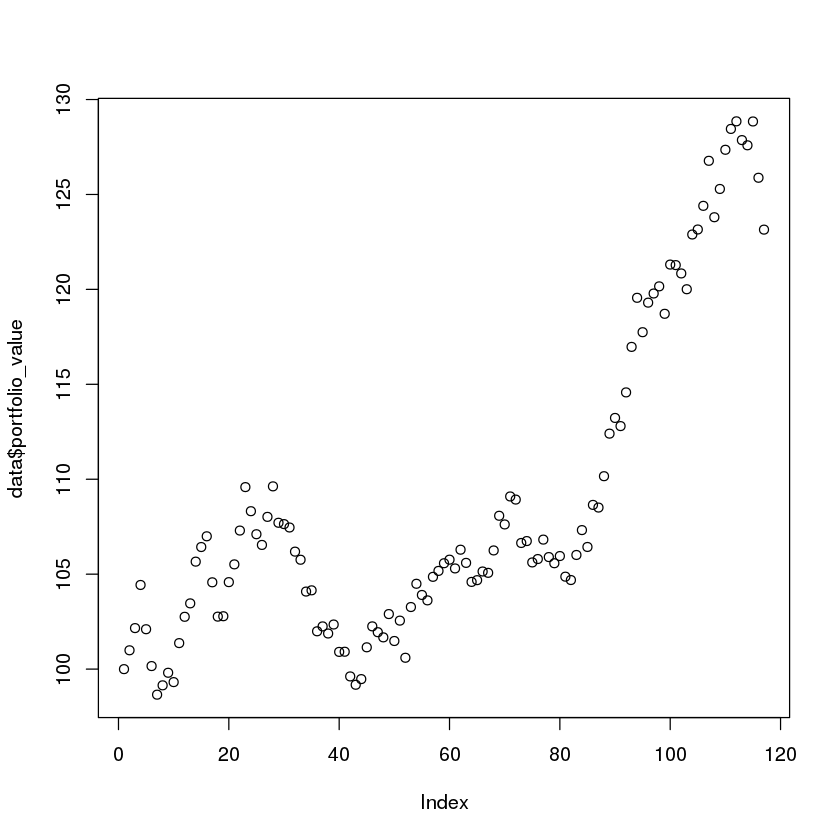

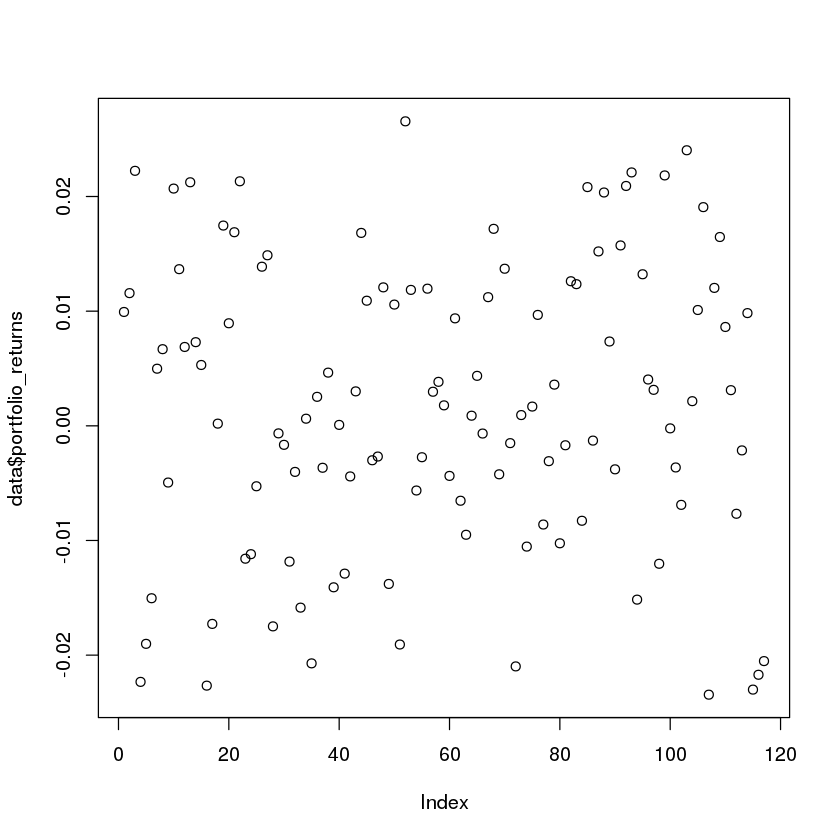

In [177]:
plot(data$portfolio_value)
plot(data$portfolio_returns)

In [128]:
install.packages("psych", repos="http://cran.us.r-project.org")
library(psych)

In [174]:
describe(data$portfolio_returns)
describe(data$GDX)
describe(data$VXX)

vars   n mean   sd median trimmed  mad   min  max range  skew kurtosis se
X1    1 117    0 0.01      0       0 0.01 -0.02 0.03  0.05 -0.17    -0.83  0

vars   n mean   sd median trimmed  mad   min  max range  skew kurtosis se
X1    1 117    0 0.01      0       0 0.01 -0.02 0.01  0.04 -0.05    -0.87  0

vars   n mean   sd median trimmed  mad   min  max range  skew kurtosis se
X1    1 117    0 0.01      0       0 0.02 -0.02 0.03  0.05 -0.16    -0.83  0

Notice that on average our portfolio returned less than the predicted amount:

In [169]:
pi*first_model$coefficients[1] + (1 - pi)*sec_model$coefficients[1]
describe(data$GDX)$mean*pi + (1-pi)*describe(data$VXX)$mean

(Intercept) 
0.002923557

[1] 0.001132207

This is driven by several issues, from the simplicity of our model to non-stationarity. If these kinds of issues interest you, go pick up a book on portfolio theory!

## Conclusion
That's it! ... We should have covered the following:
1. See the basic syntax for linear models.
2. Learn about different plotting options.
3. Study summary statistics from our linear model.
4. Extract data from the linear model object.

The example given here was a simple one from finance, but the approach is the same for all linear models, with small adjustments here and there.

# Homework:

1. Using the data set built during class, write a short script that fits all of the models, estimating the $\beta$'s for every etf.
2. Write a function that takes in the data set, estimates the betas, and prints to the screen a table containing the beta for each etf.
2. Choose one stock and print to the screen the predicted returns as a function of market returns.
3. Create two time series, each starting at $1$, and simulate their values under the predicted returns and true returns. Comment on the differences.